# Stage I

# Authors: 
-Emil Henricsson Ene

-Marc Behse

-Alessandro Consiglio

-Navid Saffari

## Predict Waste Production for its Reduction by Urban AI

### Table of Contents

* [1. Introduction](#Introduction)
* [2. Data preparation](#Data_preparation)
    * [2.1. Import of modules](#Import_of_modules)
    * [2.2. DataLoad, indexing and removal of missing values](#DataLoad_indexing_and_removal_of_missing_values )
    * [2.3. Using all Load Types and merging it with population](#merge)
* [3. Descriptive analysis of daily data](#day)
    * [3.1. Decomposing of the daily data using a weekly season](#Dec)
    * [3.2. Autocorrelation function](#Auto)
    * [3.3. Conclusion](#Conc)
* [4. Descriptive analysis monthly data](#month)
    * [4.1. Aggregate the Load Weight of waste per person on a monthly level](#agg)
    * [4.2. Plot of monthly Load Weight of waste per Person](#plot)
    * [4.3. Decomposition of the timeseries](#decII)    
* [5. Transformation of the monthly data](#trans)
    * [5.1. Dickey-Fuller-Test on untransformed timeseries](#dickey)
    * [5.2. Removal of the seasonal component](#remse)
    * [5.3. Remove the trend](#remtr)    
* [6. Autokorrelation of the monthly data](#autoc)
    * [6.1. Autocorrelation Function (ACF)](#autocf)
    * [6.2. Partial Autocorrelation Function](#autocp)
* [7. Forecast of the Timeseries](#fore)
* [8. Weather Data](#wth)
* [9. Conclusion and advice](#con)
* [10. Literature](#lit)

# 1. Introduction <a class="anchor" id="Introduction"></a>

Unsustainable patterns of consumption are routed within the peoples' daily behaviour. Those paradigmns can be traced back by analysing the governmental waste removal and recycling structure and it's volume. In our analysis, we want to support Urban AI in gaining a better conception of the waste production patterns in the city Austin. 
Our objective is to predict the futures' volume of emerging waste production for the capital city of the U.S. state of Texas.

The insights elaborated in this report can be usefull in order to manage the growth of the city, allocate resources and enhance decision-making for regional planning. 

In order to gain a high prediction accuracy, we are going to enrich the data of waste volume and type with external datasources such as weather and population growth. 

# 2. Data preparation <a class="anchor" id="Data_preparation"></a>

## 2.1 Import of modules <a class="anchor" id="Import_of_modules"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.seasonal as smts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import seasonal_naive, auto_arima
from pandas import to_datetime
from fbprophet import Prophet
from pandas import DataFrame
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import warnings

2022-03-23 23:05:12 fbprophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


## 2.2. DataLoad, indexing and removal of missing values <a class="anchor" id="DataLoad_indexing_and_removal_of_missing_values"></a>

In [2]:
#Data
waste = pd.read_csv("data/Waste_Collection___Diversion_Report__daily_.csv")

waste['Load Time'] = pd.to_datetime(waste['Load Time'], format='%m/%d/%Y %H:%M:%S %p')

waste['Month'] = waste['Load Time'].dt.month
waste['Year'] = waste['Load Time'].dt.year
waste['Date'] = waste['Load Time'].dt.date

waste = waste.set_index(waste['Load Time'])

waste = waste.dropna()

population = pd.read_csv("data/population.csv", delimiter=";", decimal=",")

pop2021 = {'Year': 2021, 'Total area population': 937397, 'Annualized growth rate': 1.2}
population = population.append(pop2021, ignore_index=True)

population = population.dropna()

## 2.3. Using all Load Types and merging it with population <a class="anchor" id="merge"></a>

I)  In the first step, we were slicing the data from '2006-01-01' to '2021-06-30' because we saw that the data   
    before 2006 was inconsistent. The July 2021 is also excluded, because in this month, only the first 11 days 
    were given. 

II) Following up, we merged the waste data of Austin (Texas) with the data on population growth. 

III) We were relying on the population growth data to calculate the amount of waste produced per person. 


In [3]:
# I) Slice time horizon
waste = waste.loc['2006-01-01': '2021-06-30']


In [6]:
# II) Merge
m_waste = waste.merge(population, on='Year', how='left', indicator=True)

In [9]:
# III) Transform and create per-person waste production
m_waste['Load Time'] = pd.to_datetime(m_waste['Load Time'], format='%m/%d/%Y %H:%M:%S %p')
m_waste = m_waste.set_index(m_waste['Load Time'])
m_waste['Load Weight pp'] = m_waste['Load Weight'] / m_waste['Total area population']
m_waste.sort_index()

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Month,Year,Date,Total area population,Annualized growth rate,_merge,Load Weight pp
Load Time,,,,,,,,,,,,,,,
2000-01-26 12:39:00,01/26/2006,RECYCLING - PAPER,2000-01-26 12:39:00,2940.0,MRF,RECYCLING,RH12,163262,1,2000,2000-01-26,NaN,NaN,left_only,NaN
2001-03-16 01:33:00,03/16/2012,BULK,2001-03-16 01:33:00,4740.0,TDS LANDFILL,BULK,BU05,522334,3,2001,2001-03-16,NaN,NaN,left_only,NaN
2001-03-16 09:38:00,03/16/2012,BULK,2001-03-16 09:38:00,4240.0,TDS LANDFILL,BULK,BU05,522335,3,2001,2001-03-16,NaN,NaN,left_only,NaN
2001-10-16 03:28:00,10/16/2012,BULK,2001-10-16 03:28:00,8260.0,TDS LANDFILL,BULK,BU16,545996,10,2001,2001-10-16,NaN,NaN,left_only,NaN
2001-10-16 11:51:00,10/16/2012,BULK,2001-10-16 11:51:00,14080.0,TDS LANDFILL,BULK,BU16,545997,10,2001,2001-10-16,NaN,NaN,left_only,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-11 07:07:45,06/28/2021,MIXED LITTER,2021-07-11 07:07:45,3140.0,TDS LANDFILL,KAB,KAB02,927260,7,2021,2021-07-11,937397.0,1.2,both,0.003350
2021-12-07 12:00:00,11/24/2020,ORGANICS,2021-12-07 12:00:00,1340.0,ORGANICS BY GOSH,YARD TRIMMINGS-ORGANICS,OBT99,927983,12,2021,2021-12-07,937397.0,1.2,both,0.001429
2021-12-21 12:41:00,12/21/2020,RECYCLING - SINGLE STREAM,2021-12-21 12:41:00,6940.0,TDS LANDFILL,RECYCLING - SINGLE STREAM,RMAU21,906125,12,2021,2021-12-21,937397.0,1.2,both,0.007403


# 3. Descriptive analysis of daily data <a class="anchor" id="day"></a>

## 3.1. Decomposing of the daily data using a weekly season <a class="anchor" id="Dec"></a>

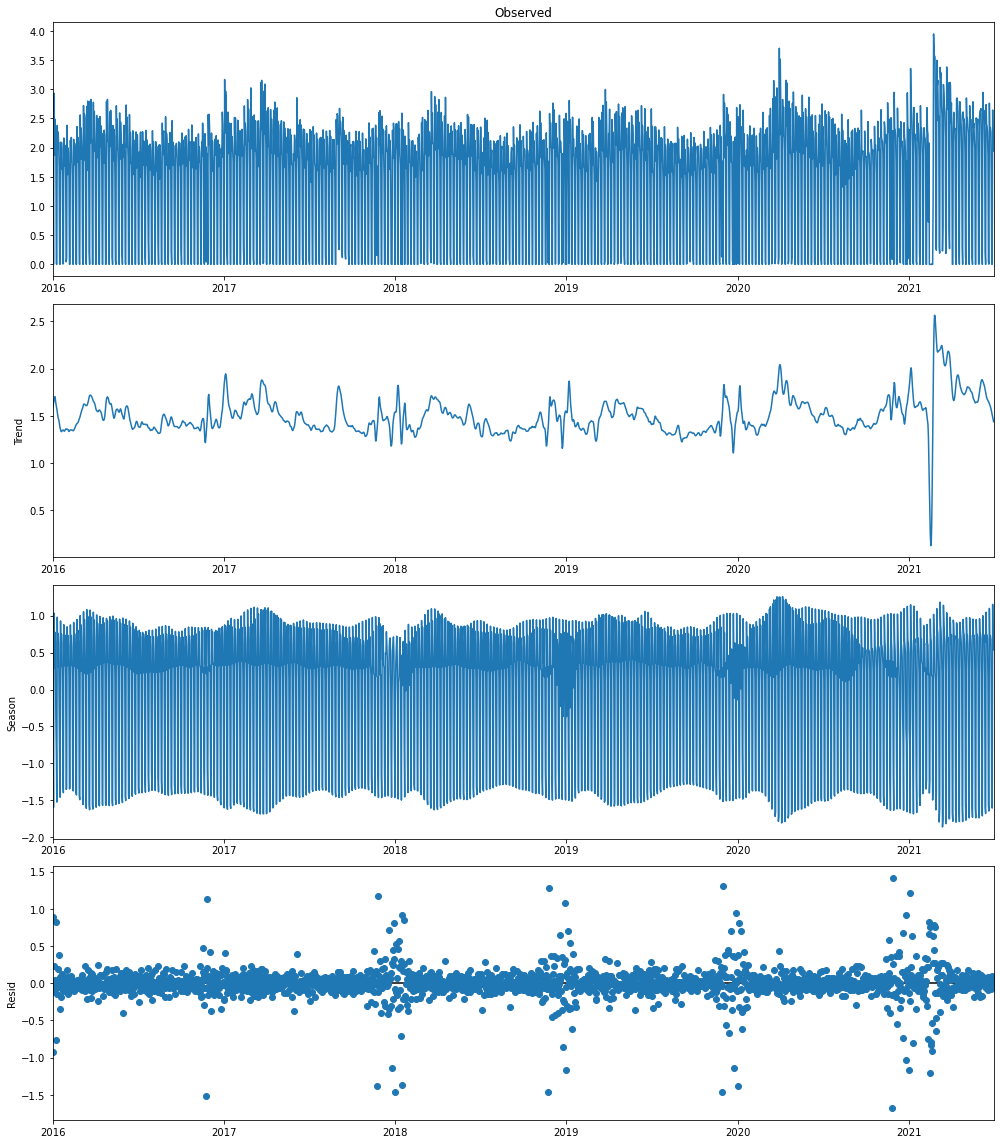

In [6]:
pp_daily_waste = m_waste['Load Weight pp'].resample('d').agg(['sum'])

plt.rcParams['figure.figsize'] = (14,16)
abc = smts.STL(pp_daily_waste['2016':], seasonal = 9).fit()
abc.plot()
plt.show()

## 3.2. Autocorrelation function <a class="anchor" id="Auto"></a>

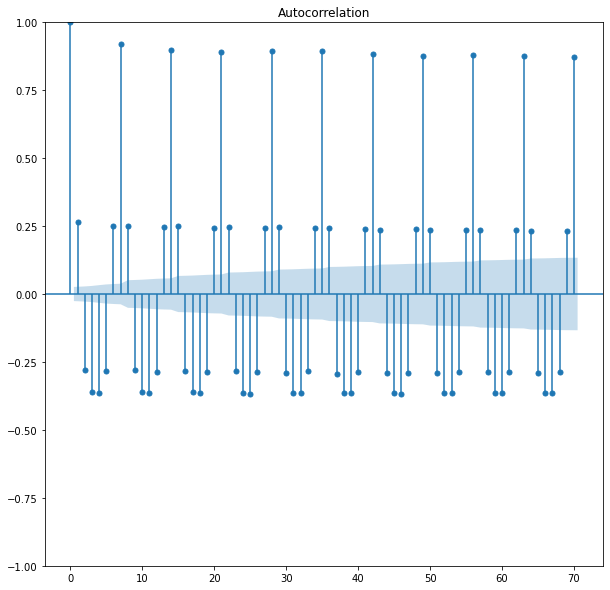

In [7]:
#ACF, daily, 10 weeks of lags

plt.rcParams['figure.figsize'] = (10,10)
plot_acf(pp_daily_waste, lags = 7*10)
plt.show()

## 3.3 Conclusion <a class="anchor" id="Conc" ></a>

The aim of this Chapter was to gain a general perspective on the daily data. The decomposition of the time series has shown some outliers of the residuals with unconventional patterns. At that point, we were not able to explain those patterns. Therefore, we have decided aggregating the data on a monthly level in the next chapter. 

# 4. Descriptive analysis monthly data <a class="anchor" id="month"></a>

The aim of this Chapter is to gain a general perspective on the monthly data.


## 4.1. Aggregate the Load Weight of waste per person on a monthly level <a class="anchor" id="agg"></a>

In [8]:
# Transformation into monthly data and depicting the first 5 rows of the dataset

pp_waste = m_waste['Load Weight pp'].resample('m').agg(['sum'])
pp_waste.head()

,sum
Load Time,
2006-01-31,48.935382
2006-02-28,38.672231
2006-03-31,55.052177
2006-04-30,48.093367
2006-05-31,60.692428


##  4.2. Plot of monthly Load Weight of waste per Person <a class="anchor" id="plot"></a>

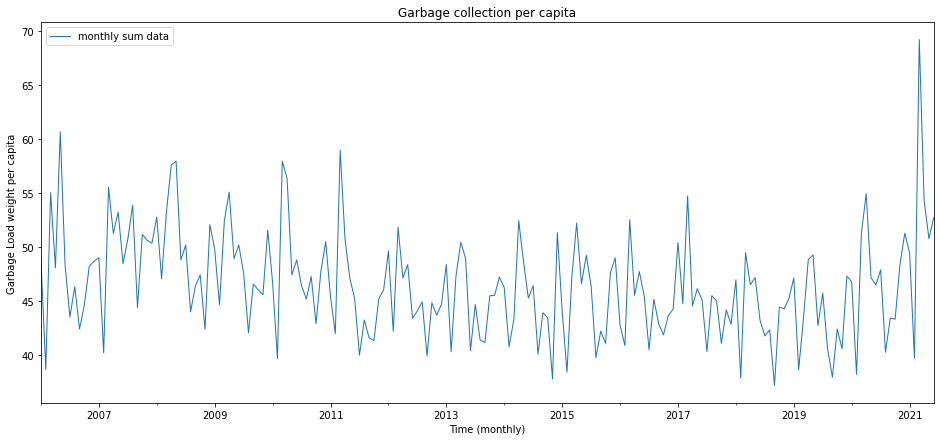

In [9]:
# This plot depicts the actual time series data.

plt.rcParams['figure.figsize'] = (16,7)
pp_waste.plot(linewidth = 1)
plt.title("Garbage collection per capita")
plt.xlabel("Time (monthly)")
plt.ylabel("Garbage Load weight per capita")
plt.legend(["monthly sum data"])

## 4.3. Decomposition of the timeseries <a class="anchor" id="decII"></a>

I) The first plot depicts the actual time series data.

II) In the second plot, the trend of the data can be analyzed. From 2006 to 2008 we can observe a slight increase  
    in Load Weight per person. For the time period from 2008-2019 we can observe a steady decrease. From 2020-2021, 
    the Load Weight per person is increasing sharply.

III)The third plot shows the seasonality. The seasonal effects are very strong (positive) in the beginning of each     year. There is a second peak in the middle of each year.

IV)In the fourth plot, we can observe the distribution of the residuals. There are no specific patterns observable    within that plot.

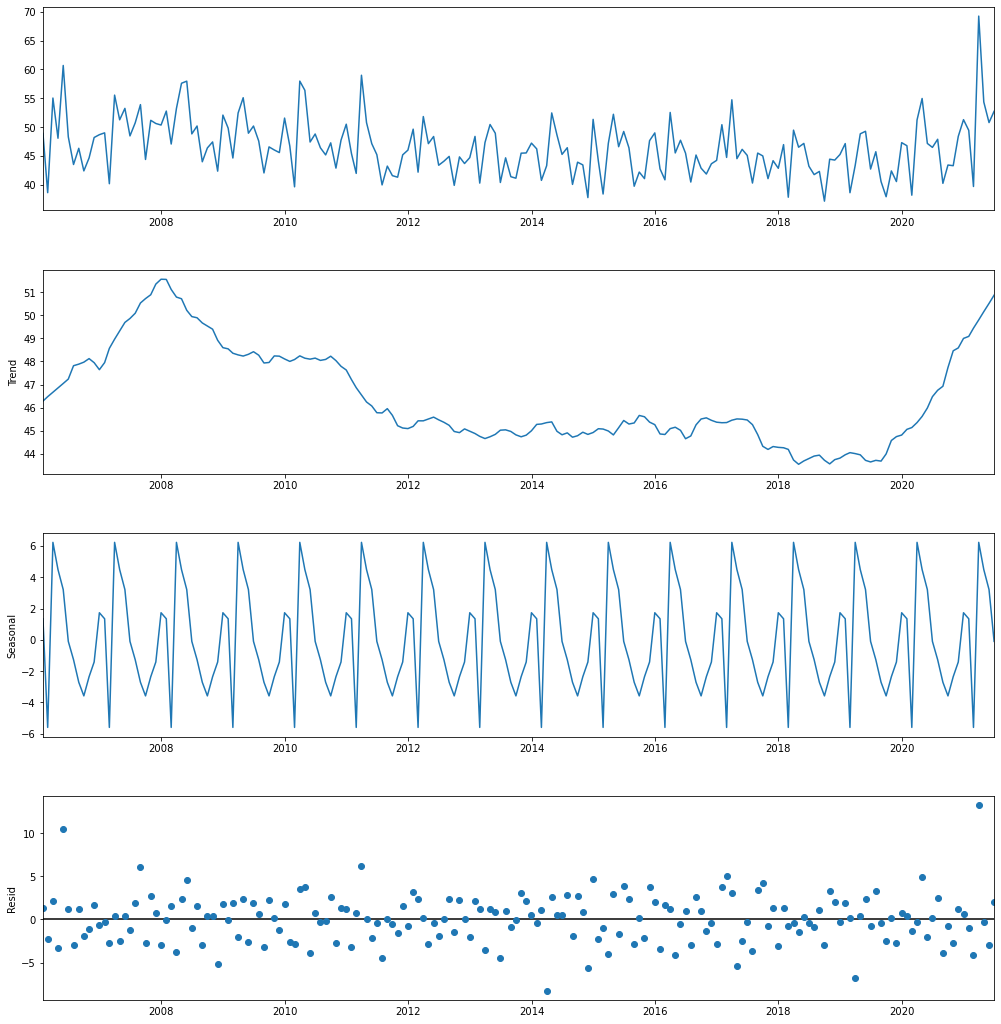

In [10]:
y=m_waste['Load Weight pp'].resample('m').agg(['sum'])
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,15)
    plt.show()
seasonal_decompose(y)


# 5. Transformation of the monthly data <a class="anchor" id="trans"></a>

The aim of this chapter is to transform the monthly data by removing the seasonal effects and the trend. In order to see, if our steps of transformation are successfull, we are going to applying a Dickey-Fuller-Test after every transformation. In the end of this chapter, we are going to sum up our findings.

## 5.1. Dickey-Fuller-Test on untransformed timeseries <a class="anchor" id="dickey"></a>

In [11]:
result = adfuller(pp_waste['sum'].dropna())

print("Test statistic = {:.4f}".format(result[0]))
print("P-value = {:.4f}".format(result[1]))
# Result p-value > 0.05. Hence there is not enough evidence to reject that the data is not stationarity


Test statistic = -1.1515
P-value = 0.6941


## 5.2. Removal of the seasonal component <a class="anchor" id="remse"></a>

In [12]:
pp_waste['sum diff 12'] = pp_waste['sum'].diff(periods = 12)

result = adfuller(pp_waste['sum diff 12'].dropna())

print("Test statistic = {:.4f}".format(result[0]))
print("P-value = {:.4f}".format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# Result p-value < 0.05. After removing the seasonal component, there is not enough evidence
# to accept the H0 on a 5% level of significance. Rejecting the null hypothesis means that the process 
#has no unit root, and in turn that the time series is stationary 
#or does not have time-dependent structure. 


Test statistic = -3.0274
P-value = 0.0324
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


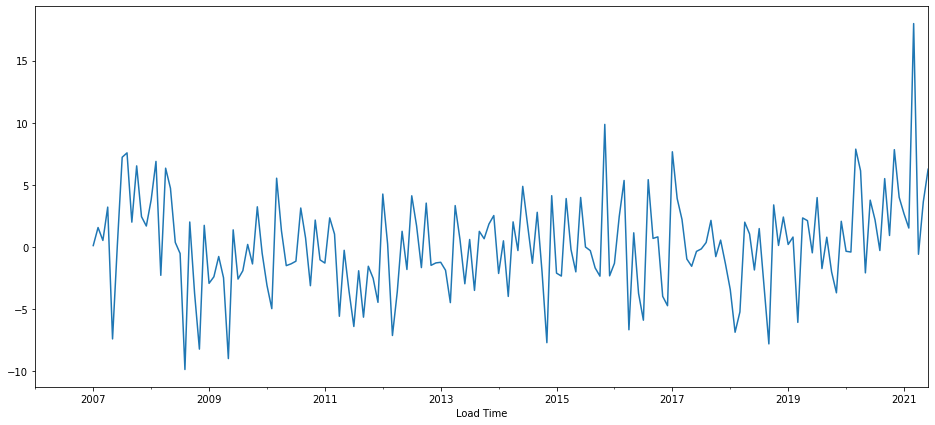

In [13]:
plt.rcParams['figure.figsize'] = (16,7)
pp_waste['sum diff 12'].plot()
xlabel='Load Time'


## 5.3 Remove the trend <a class="anchor" id="remtr"></a>


In [14]:
# In order to remove the trend form the timeseries, we used first differences.

pp_waste['sum_log'] = np.log(pp_waste['sum'])

pp_waste['sum_log_diff'] = pp_waste['sum_log'].diff(periods=1)

result = adfuller(pp_waste['sum_log_diff'].dropna())

print("Test statistic = {:.4f}".format(result[0]))
print("P-value = {:.4f}".format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Result p-value < 0.05. After removing the trend component, there is enough evidence
# to rejet the H0 on a 5% level of significance and accept the H1.
#The data does not have a unit root and is stationary.



Test statistic = -4.8270
P-value = 0.0000
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


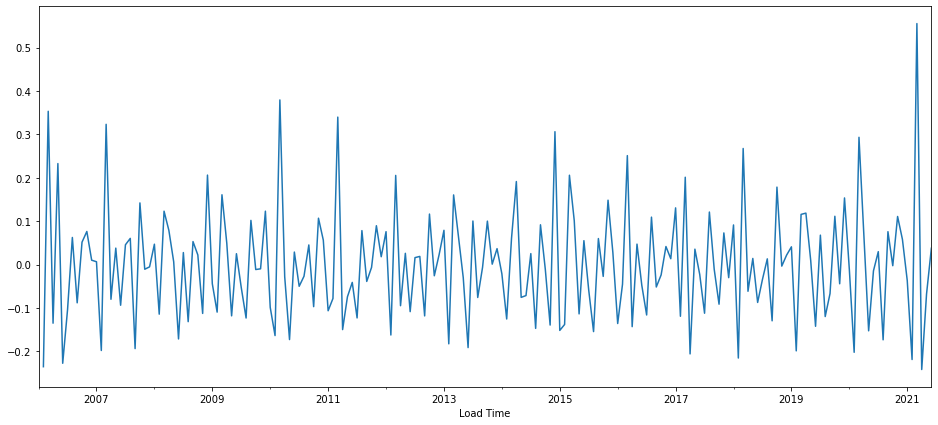

In [15]:
plt.rcParams['figure.figsize'] = (16,7)
pp_waste['sum_log_diff'].plot()
xlabel='Load Time'

## 5.4. Conclusion of this chapter

After removing the seasonal component and the trend component, we were able to achive stationarity of the data. 
There is no systematic change in the mean, variance, and no systematic fluctuation anymore (Hirschle, 2021). As we made sure to remove any trend within the data, we can now focus on performing a autocorrelation function within the next chapter.

# 6. Autokorrelation of the monthly data <a class="anchor" id="autoc"></a>

In order to find an adequate choice for the forecasting model, we decided to analyze the autocorrelation function, as well as the partial autocorrelation function.

## 6.1. Autocorrelation Function (ACF)<a class="anchor" id="autocf"></a>

The plot below shows the monthly autocorrelation function plotted for 12 lags. During the first lags, we can see a decreasing echo, for the last lags, the autocorrelation is increasing. For lag 12, the autocorrelation is the highest. This means that the current month has a high correlation with the same month in the last year.  

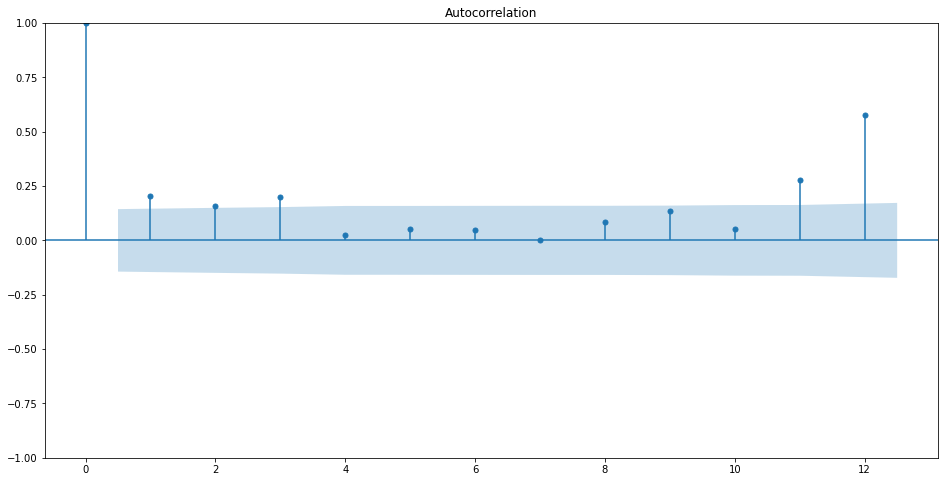

In [16]:
plt.rcParams['figure.figsize'] = (16,8)
plot_acf(pp_waste['sum'], lags = 12)
plt.show()

Following up, we increased the timespan by plotting the autocorrelation plot over 10 years. The echo is diminishing but we can still see the shocks in lag 11 & lag 12.

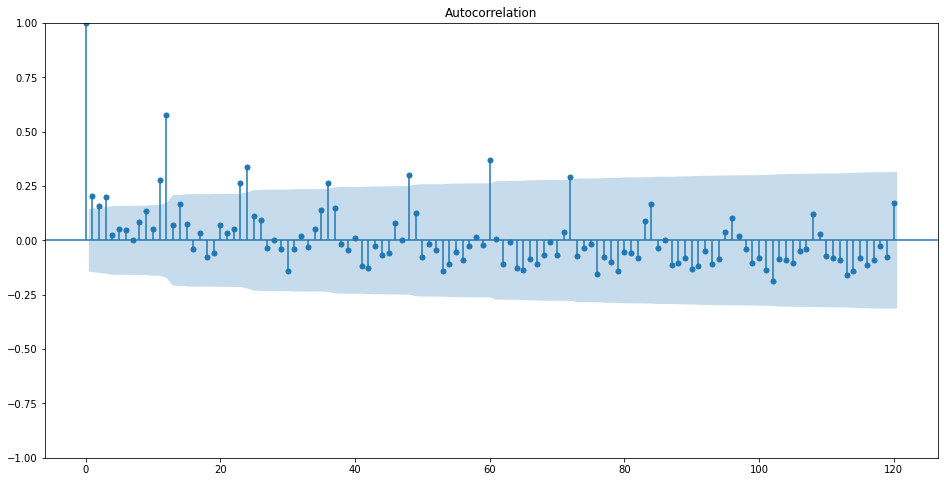

In [17]:
plt.rcParams['figure.figsize'] = (16,8)
plot_acf(pp_waste['sum'], lags = 12*10)
plt.show()

## 6.2. Partial Autocorrelation Function <a class="anchor" id="autocp"></a>

The plot for partial autocorrelation depicts the same pattern. First, the echo of the correlation of the error terms is decreasing with every lag. For the last lags, the autocorrelation of the error term is increasing sharply. 

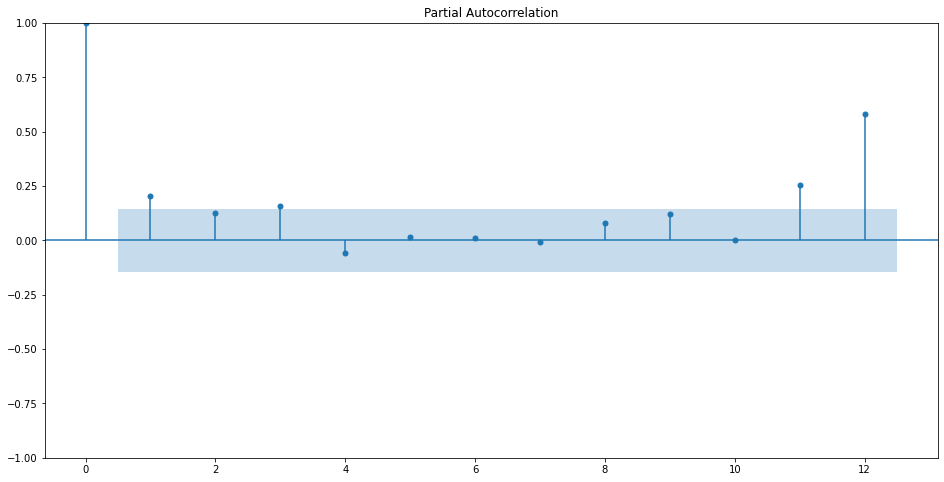

In [28]:
plt.rcParams['figure.figsize'] = (16,8)
x= plot_pacf(pp_waste['sum'],lags = 12)
warnings.filterwarnings('ignore')

In general, choosing an autogregression model is a good fit, if the echo in the autocorrelation is decreasing steadily, leaving only the first lags with a significant result of autocorrelation. If the autocorrelation is decreasing drastically (shock) a Moving-Average-Model would be a good choice (Hirschle, 2021). As our autocorrelation plots depicts both characteristics, we deecided to apply an Autoregression Integrated Moving Averages (ARIMA) approach.

# 7. Forecast of the Timeseries  <a class="anchor" id="fore"></a>

For the forecast of the timeseries has been decided to try two different models. The first one is an ARIMA with a seasonal lenght of 12 value, which represents the seasonal autoregressive order or number of Lags. The second one is the Naive seasonal where each forecast is forced to be equal to the last observed value from the same season, in this case the same months of the last year. To evaluate the fit of this models has been used the RMSE methods as metric to decide which one fit better the data.

# 7.1. In sample Prediction

A In sample prediction has been calculated on the detrended data. The dataset has been splitted in two parts: training set that includes the 80% of the data and a test set incuding the other 20%. The model created have also given a confidence interval at 80% and 95% level.

In [19]:
### FORECAST
y=pp_waste["sum_log_diff"]
y=np.array(y).T
y=np.squeeze(y)
horizon = 24
ap_train = y[:-horizon]
ap_test = y[-horizon:]

series_train = pd.DataFrame(
    {
        'ds': pd.date_range(start='2006-01-31', periods=ap_train.size, freq='M'),
        'y': ap_train
    },
    index=pd.Index([0] * ap_train.size, name='unique_id')
)

In [31]:
fcst = StatsForecast(
    series_train, 
    models=[(auto_arima, 12),(seasonal_naive, 12)], 
    freq='M', 
    n_jobs=1
)
forecasts = fcst.forecast(24, level=(80, 95))

forecasts["y_test"]=ap_test
warnings.filterwarnings('ignore')
forecasts

,ds,auto_arima_season_length-12_mean,auto_arima_season_length-12_lo-80,auto_arima_season_length-12_lo-95,auto_arima_season_length-12_hi-80,auto_arima_season_length-12_hi-95,seasonal_naive_season_length-12,y_test
unique_id,,,,,,,,
0,2019-07-31,-0.006658,-0.098697,-0.147419,0.085380,0.134102,-0.034211,0.067755
0,2019-08-31,0.008505,-0.119016,-0.186521,0.136027,0.203532,0.013124,-0.119814
0,2019-09-30,-0.084019,-0.211540,-0.279045,0.043502,0.111008,-0.129639,-0.066826
0,2019-10-31,0.115639,-0.011882,-0.079387,0.243161,0.310666,0.178429,0.111251
0,2019-11-30,-0.002326,-0.129848,-0.197353,0.125195,0.192700,-0.003590,-0.044314
0,2019-12-31,0.014072,-0.113449,-0.180954,0.141594,0.209099,0.021714,0.153501
0,2020-01-31,0.026467,-0.101054,-0.168560,0.153988,0.221494,0.040838,-0.011225
0,2020-02-29,-0.128887,-0.256409,-0.323914,-0.001366,0.066139,-0.198871,-0.202196
0,2020-03-31,0.074923,-0.052598,-0.120104,0.202444,0.269950,0.115604,0.293231


Before the plotting part, the metrics has been calculated using a RMSE ( Root Mean Squared Error), which calculates the standard deviation of the residuals of the model. The ARIMA Seasonal model gives a lower value, it means that should be considered better than the Naive Seasonal because the distance between the actual values and the predicted one are smaller.

In [32]:
### METRICS TO EVALUATE THE TWO MODELS
from sklearn.metrics import mean_squared_error
import math
# SEASONAL NAIVE LENGHT 12
RMSE=math.sqrt(mean_squared_error(forecasts['y_test'], forecasts['seasonal_naive_season_length-12']))
print(f' The RMSE value for the Naive seasonal method with 12 lags = {RMSE}')

# ARIMA SEASONAL 12 LENGHT
RMSE=math.sqrt(mean_squared_error(forecasts['y_test'], forecasts['auto_arima_season_length-12_mean']))
print(f' The RMSE value for auto arima season model with 12 lenght mean = {RMSE}')

 The RMSE value for the Naive seasonal method with 12 lags = 0.16211318434496833
 The RMSE value for auto arima season model with 12 lenght mean = 0.1551806168149587


# 7.2.1 Plot

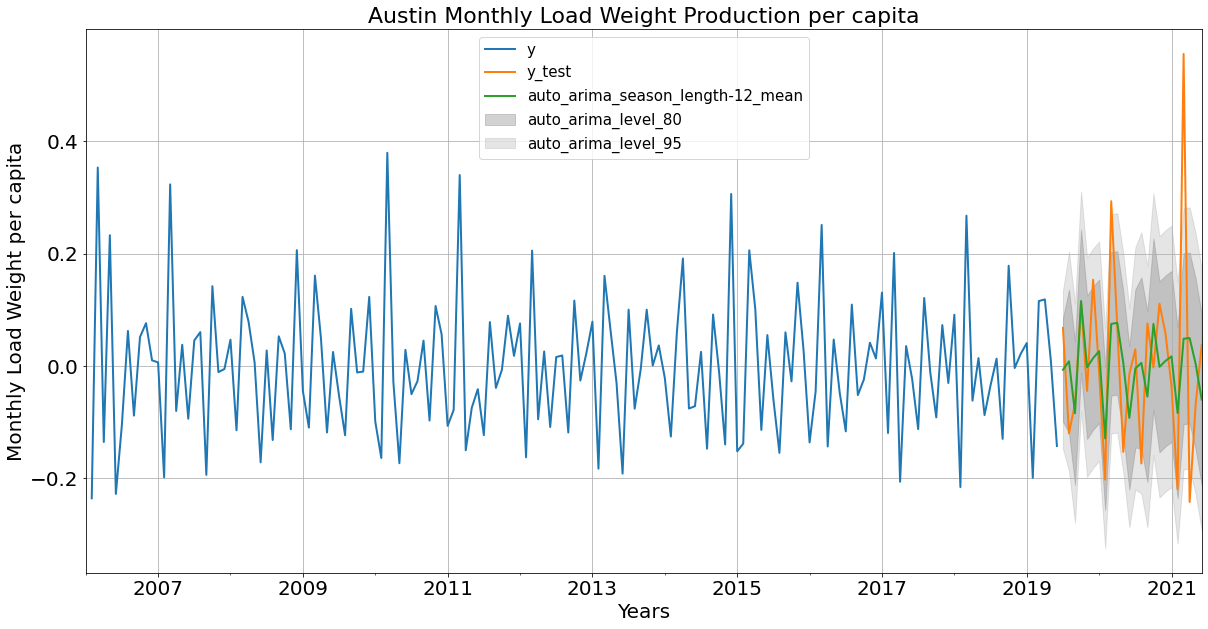

In [33]:
### AUTO ARIMA SEASONAL LENGHT 12 MEAN MODEL
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
df_plot = pd.concat([series_train, forecasts]).set_index('ds')
df_plot[['y','y_test','auto_arima_season_length-12_mean']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['auto_arima_season_length-12_lo-80'], 
                df_plot['auto_arima_season_length-12_hi-80'],
                alpha=.35,
                color='grey',
                label='auto_arima_level_80')
ax.fill_between(df_plot.index, 
                df_plot['auto_arima_season_length-12_lo-95'], 
                df_plot['auto_arima_season_length-12_hi-95'],
                alpha=.2,
                color='grey',
                label='auto_arima_level_95')
ax.set_title('Austin Monthly Load Weight Production per capita', fontsize=22)
ax.set_ylabel('Monthly Load Weight per capita', fontsize=20)
ax.set_xlabel('Years', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

The predicted values using the ARIMA model seem fit well the test data. We can see that the forecasted 24 months is a good match for the real observations, especially when the bounds are taken into accoun. At glance it's possible to see that from year 2020 the Monthly Load Weight per capita reached higher peaks compared to the past especially in March 2021 where it's possible to see the highest peak value. Probably the Covid-19 situation has greatly influenced the amount of rubbish produced per capita. Especially in the periods of total lockdown that have occurred in the last two years where people being forced to stay at home probably producing a greater amount of waste. The prediction that is made by our model obviously cannot capture these sudden variations with the data provided in past years.

# 7.2. Out of Sample Prediction

In this prediction another method has been used. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. In particular works well with:

· Seasonal effects caused by human behavior: weekly, monthly and yearly cycles, dips and peaks on public holidays.

· Changes in trend due to new products and market events.

· Outliers

In [35]:
# Data preparation for the Out of Sample prediction
Y=DataFrame(pp_waste["sum_log_diff"])
Y=Y.reset_index()

A prediction beyond the training data has been done in order to understand if effectively Covid Period Data have influenced or not in the serie. This can be achieved in the same way as an in-sample forecast and simply specify a different forecast period, in this case we decided to predict the value until july 2024.

In [43]:
# Preparation of the time period for the prediction and summary of the Forecast
import datetime
Y.columns = ['ds', 'y']
# define the model
model = Prophet(daily_seasonality=True,weekly_seasonality=True)
# fit the model
model.fit(Y)
# date for the forecast

date1 = "2021-07-31"  #start date
date2 = "2024-07-31"  # end date

month_list = [i.strftime('%Y-%m-%d') for i in pd.date_range(start=date1, end=date2, freq='MS')]
month_list=DataFrame(month_list)

month_list.columns=['ds']
month_list['ds']= to_datetime(month_list['ds'])

forecast = model.predict(month_list)
# summarize the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-08-01,-0.121322,-0.196916,-0.040603
1,2021-09-01,0.084144,0.011385,0.169392
2,2021-10-01,-0.012418,-0.088453,0.069716
3,2021-11-01,-0.039526,-0.122970,0.039807
4,2021-12-01,0.122205,0.048946,0.201229


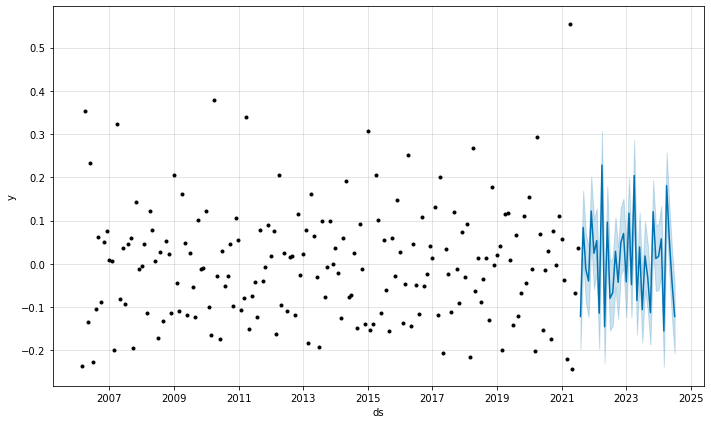

In [45]:
# plot forecast
model.plot(forecast)
plt.show()

The plot above depict the prediction from a prophet method since our model seems seasonally affected especially during the beginning of every year. The prediction shows that the trend of the serie follow the pattern of the years before covid and seems to be steady during the years. The only thing that we can confirm right now is that for the moment only the lockdown periods have effected the serie in 2020-2021. Apparently from 2021 to 2024 if the situation doesn't change from now, the garbage situation should return to normal values of the past.

## 8. Weather Data <a class="anchor" id="wth"></a>

We have already shown that the waste-data follows a strong seasonal pattern. Therefore we're interested in using this seasonality for predicting future values of waste production. We're going to use weather data from Austin, which also follows a strong seasonality, to try and predict waste production with a vector autoregressive model (VAR model).

The weather data is measured as average degrees in Fahrenheit per month. Waste is measured as waste per person per month. Weather data for Austin was unfortunantley only available for the period 2013-12 to 2017-07.

In [46]:
#Load data
wth = pd.read_csv("data/austin_weather.csv")
wth['Date'] = pd.to_datetime(wth['Date'], format='%Y/%m/%d')
wth = wth.set_index(wth['Date'])
pp_waste = m_waste['Load Weight pp'].resample('m').agg(['sum'])
#Find average monthly temps
m_wth = wth['TempAvgF'].resample('m').agg(['mean'])

#Create merged data of waste per person and temp
m_ppwaste = pp_waste.loc['2013-12': '2017-07']
merge = pd.DataFrame(m_ppwaste).join(m_wth)
merge.columns = ['waste', 'temp']


In [47]:
print("Test for stationarity: \n---p-values for stationarity test--- \n")
print('Waste:')
print(adfuller(merge['waste'])[1])
print()
print('Temp:')
print(adfuller(merge['temp'])[1])
print()
print('Temp series is not stationary')

Test for stationarity: 
---p-values for stationarity test--- 

Waste:
1.1498088901938864e-05

Temp:
0.977201456897939

Temp series is not stationary


In [48]:
#Difference the Temp series by 1 lag
diff_merge = merge.copy()
diff_merge['temp'] = diff_merge['temp'].diff()
diff_merge = diff_merge[1:]

print("---p-values for stationarity test--- \n")
print('Waste:')
print(adfuller(diff_merge['waste'])[1])
print()
print('Differenced Temp:')
print(adfuller(diff_merge['temp'])[1])
print()
print('Using the first difference of Temp we now have stationarity in both series')

---p-values for stationarity test--- 

Waste:
2.2278142197142864e-05

Differenced Temp:
9.683243092263455e-07

Using the first difference of Temp we now have stationarity in both series


In [49]:
#Training- and Test set of stationary data
diff_merge_train = diff_merge.loc[:'2016-07']
diff_merge_test = diff_merge.loc['2016-08':]

In [50]:
#IC's of VAR-model to achieve optimal lag order
model = VAR(diff_merge_train)
print(model.select_order(maxlags = 9).summary())
print()
print('Using the VAR-class methods we can get the optimal order of lags = 9')

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       6.969       7.068       1063.       6.992
1       6.881       7.179       977.1       6.951
2       6.944       7.439       1053.       7.060
3       5.819       6.513       352.4       5.983
4       5.792       6.685       362.8       6.002
5       5.747       6.838       381.4       6.004
6       5.271       6.560       276.9       5.575
7       4.108       5.595       111.1       4.458
8       3.617       5.303       103.0       4.014
9      1.833*      3.717*      36.89*      2.277*
-------------------------------------------------

Using the VAR-class methods we can get the optimal order of lags = 9


In [51]:
#Fit VAR-model, VARMAX model without moving average(MA), 9 lags
var_model = VARMAX(diff_merge_train, order = (9,0))
fitted_model = var_model.fit(disp = False)

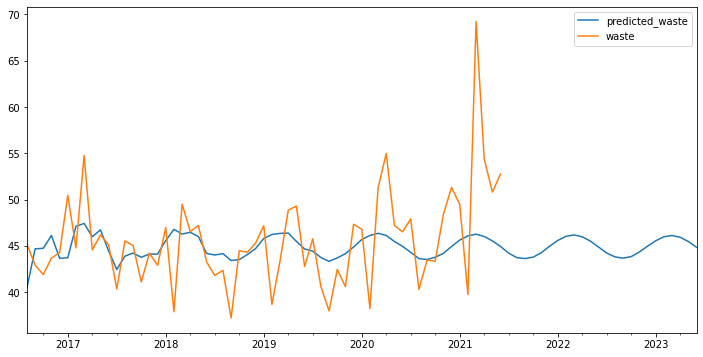

In [52]:
#Create a forecast for the rest of the years for which we have waste data available and also two years further into the future
steps = len(pp_waste['2016-08':]) + 24
predict = fitted_model.get_prediction(start = len(diff_merge_train), end = len(diff_merge_train) + steps - 1)

predictions = predict.predicted_mean
predictions.columns=['predicted_waste', 'predicted_temp']

test = pp_waste.copy()
test.columns = ['waste']
test_vs_pred = pd.DataFrame(predictions['predicted_waste']).join(test)
test_vs_pred.plot(figsize = (12,6))
plt.show()

The forecast shows that the VAR model predicts a stationary series. Altough the model greatly underestimates both the maximums and the minimums of the seasonality in the waste data, it still provides insight into the underlying pattern of when waste production peaks and bottoms. This can be used to forecast when to expect large amounts of waste, which seems to occur somewhere in Q1 of each year.

## 9. Conclusion and advice <a class="anchor" id="con"></a>


The peak during the beginning of every year seems to influence considerably the quantity of garbage producted per capita. Find a solution to that will give a better organizations for the waste disposal so as to spread them over different periods in order not to burden the recycling and disposal system.

## 10. Literature <a class="anchor" id="lit"></a>

Hirschle, J.(2021). Machine Learning für Zeitreihen. Hanser Verlag, München. S.117

Hyndman, R. (2021). Forecasting: Principles and Practice chap. 5.1